In [2]:
import sys
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.manifold import TSNE

lambert_crs = ccrs.LambertConformal(
    central_longitude=-107.0,
    central_latitude=50.0,
    standard_parallels=[50.0, 50.0],
    false_easting=5632642.22547,
    false_northing=4612545.65137
)

In [25]:
# def subset_by_latlon(data, lon_min, lon_max, lat_min, lat_max):

#     lon = data['lon']
#     lat = data['lat']

#     mask = (lon >= lon_min) & (lon <= lon_max) & (lat >= lat_min) & (lat <= lat_max)
#     y_indices, x_indices = np.where(mask)

#     x_min, x_max = x_indices.min(), x_indices.max()
#     y_min, y_max = y_indices.min(), y_indices.max()

#     subset = data.isel(x=slice(x_min, x_max + 1), y=slice(y_min, y_max + 1))

#     return subset

# def slice_time(dataset: xr.Dataset, time: datetime):
#     output = dataset.sel(time=time, method="nearest")
#     return output

In [ ]:
main = gpd.read_file('../data/full_globfire.shp')
main = pd.concat([main,main.bounds], axis=1)

A function to combine all the single-variable files from a given fire event into one file:

In [102]:
def vertical_stack(id):
    date = main[main['_uid_']==id]['initialdat'].values[0].astype('M8[D]').astype(str).replace('-', '')
    id = "{:.1f}".format(id)
    air = xr.open_dataset(f"../weatherregimes/assets/air/air_{id}_{date}.nc")
    uwnd = xr.open_dataset(f"../weatherregimes/assets/uwnd/uwnd_{id}_{date}.nc")
    vwnd = xr.open_dataset(f"../weatherregimes/assets/vwnd/vwnd_{id}_{date}.nc")
    shum = xr.open_dataset(f"../weatherregimes/assets/shum/shum_{id}_{date}.nc")
    omega = xr.open_dataset(f"../weatherregimes/assets/omega/omega_{id}_{date}.nc")
    full = xr.merge([air,shum,omega,uwnd,vwnd]).drop_vars(['Lambert_Conformal'])

    for var_name in full.data_vars:
        var = full[var_name]
        var.encoding['_FillValue'] = var.encoding['missing_value']

    full.to_netcdf(f'../weatherregimes/assets/all/all_{id}_{date}.nc')
    return full

Combining the first 10 to check

In [ ]:
for id in main['_uid_'][:10]:
    try:
        vertical_stack(id)
    except:
        print("failed")

Now lets combine the different events into one dataset:

In [109]:
one = xr.open_dataset("/Users/eliotcarlson/Desktop/columbia/capstone/weatherregimes/assets/all/all_17.0_20020110.nc")
two = xr.open_dataset("/Users/eliotcarlson/Desktop/columbia/capstone/weatherregimes/assets/all/all_18.0_20020111.nc")

full = xr.merge([one,two])

Here's how we put the data on the levels we care about:

In [42]:
full = full.stack(location=('y', 'x')).sel(time=full.time[1],method="nearest")
#full = full.stack(spacetime=('y', 'x', 'time'))
full = full.drop_vars(['Lambert_Conformal']).to_stacked_array("var-lvl",sample_dims=["location"])
coordinates = full.coords

X = full[~np.isnan(full).any(axis=1)]

Playing with Dimension Reduction

In [ ]:
air = xr.open_dataset("air.200309.nc")
uwnd = xr.open_dataset("uwnd.200309.nc")
vwnd = xr.open_dataset("vwnd.200309.nc")
# shum = xr.open_dataset("../data/NARR/shum.200009.nc")
omega = xr.open_dataset("omega.200309.nc")
hgt = xr.open_dataset("hgt.200309.nc")
# full = xr.merge([air,shum,omega,uwnd,vwnd])
full = xr.merge([air,omega,hgt,uwnd])

In [46]:
pca = decomposition.PCA(n_components=1)
pca_result = pca.fit_transform(X.values)  # Use the raw values from the stacked array

# Reconstruct as an xarray.DataArray with the original coordinates
pca_da = xr.DataArray(
    pca_result, 
    coords={'location': X['location'], 'component': [1]}, 
    dims=['location', 'component']
)

In [ ]:
first_pc_unstacked = pca_da.unstack('location')

# Now plot the first principal component using x, y coordinates as a map
plt.figure(figsize=(8, 6))
first_pc_unstacked.plot(cmap='viridis')
plt.title('First Principal Component by X, Y Coordinates')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': lambert_crs})
first_pc_unstacked.plot(ax=ax, cmap='viridis',transform=None)
ax.coastlines(resolution='50m')
plt.title("North America by Value of 1st Principle Component")
plt.show()

In [38]:
pca = decomposition.PCA(n_components=2)
pca.fit(X)
Y = pca.transform(X)

In [ ]:
full_pca = decomposition.PCA()
full_pca.fit(X)

explained_variance = full_pca.explained_variance_ratio_

plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance, 'o-', markersize=8, color='blue', label='Explained Variance')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

In [ ]:
plt.scatter(Y[:,0], Y[:,1], color='blue', marker='o')
plt.axis('equal')
plt.show()

In [ ]:
print(pca.explained_variance_ratio_)
print(pca.components_)

In [21]:
r = np.random.randint(0,10,size=(500,87))
pcar = decomposition.PCA(n_components=2)
pcar.fit(r)
pcar.explained_variance_ratio_

array([0.02300333, 0.02253702])

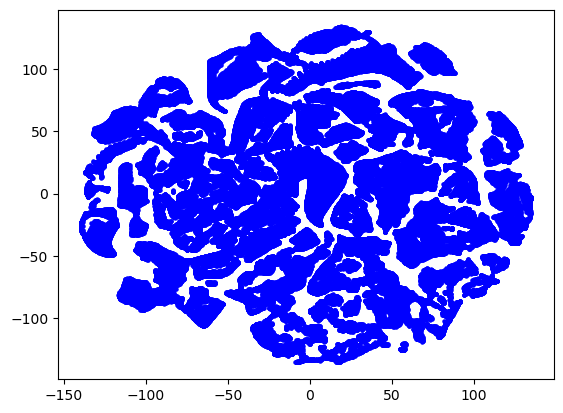

In [17]:
pca_10 = decomposition.PCA(n_components=10)
pca_10.fit(X)
Z = pca_10.transform(X)
tsne_result = TSNE(n_components=2, random_state=1).fit_transform(Z)

plt.scatter(tsne_result[:, 0], tsne_result[:, 1], s=5, color='blue')
plt.show()